In [1]:
from Samplers.sampler_test import *
from Samplers.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv')
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']]

In [2]:
mean_bmi = bmi_sbp_data['bmi'].mean()
mean_sbp = bmi_sbp_data['sbp'].mean()
std_bmi = bmi_sbp_data['bmi'].std()
std_sbp = bmi_sbp_data['sbp'].std()
bmi_sbp_data.loc[:, 'bmi'] = (bmi_sbp_data['bmi'] - mean_bmi) / std_bmi
bmi_sbp_data.loc[:, 'sbp'] = (bmi_sbp_data['sbp'] - mean_sbp) / std_sbp
bmi_bounds = (np.array([18, 25, 30, np.inf])-mean_bmi)/std_bmi
sbp_bounds = (np.array([140, 160, np.inf])-mean_sbp)/std_sbp


In [3]:
from scipy.spatial.distance import pdist

def h1(mu):
    return np.min(pdist(mu))

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0


Running Gibbs Sampler for Run 1


Sampling:   0%|          | 0/4000 [00:00<?, ?it/s]

/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:189: RuntimeWarning: divide by zero encountered in log
  + np.log(h(proposed_mu))
/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:193: RuntimeWarning: divide by zero encountered in log
  + np.log(h(mu))
/Users/yunjiaqi/Desktop/M4R/Samplers/sampler_test.py:187: RuntimeWarning: invalid value encountered in scalar subtract
  log_acceptance_rate = (
Sampling: 100%|██████████| 4000/4000 [04:46<00:00, 13.98it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 4000/4000 [04:44<00:00, 14.08it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 4000/4000 [04:42<00:00, 14.17it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 4000/4000 [04:43<00:00, 14.12it/s]


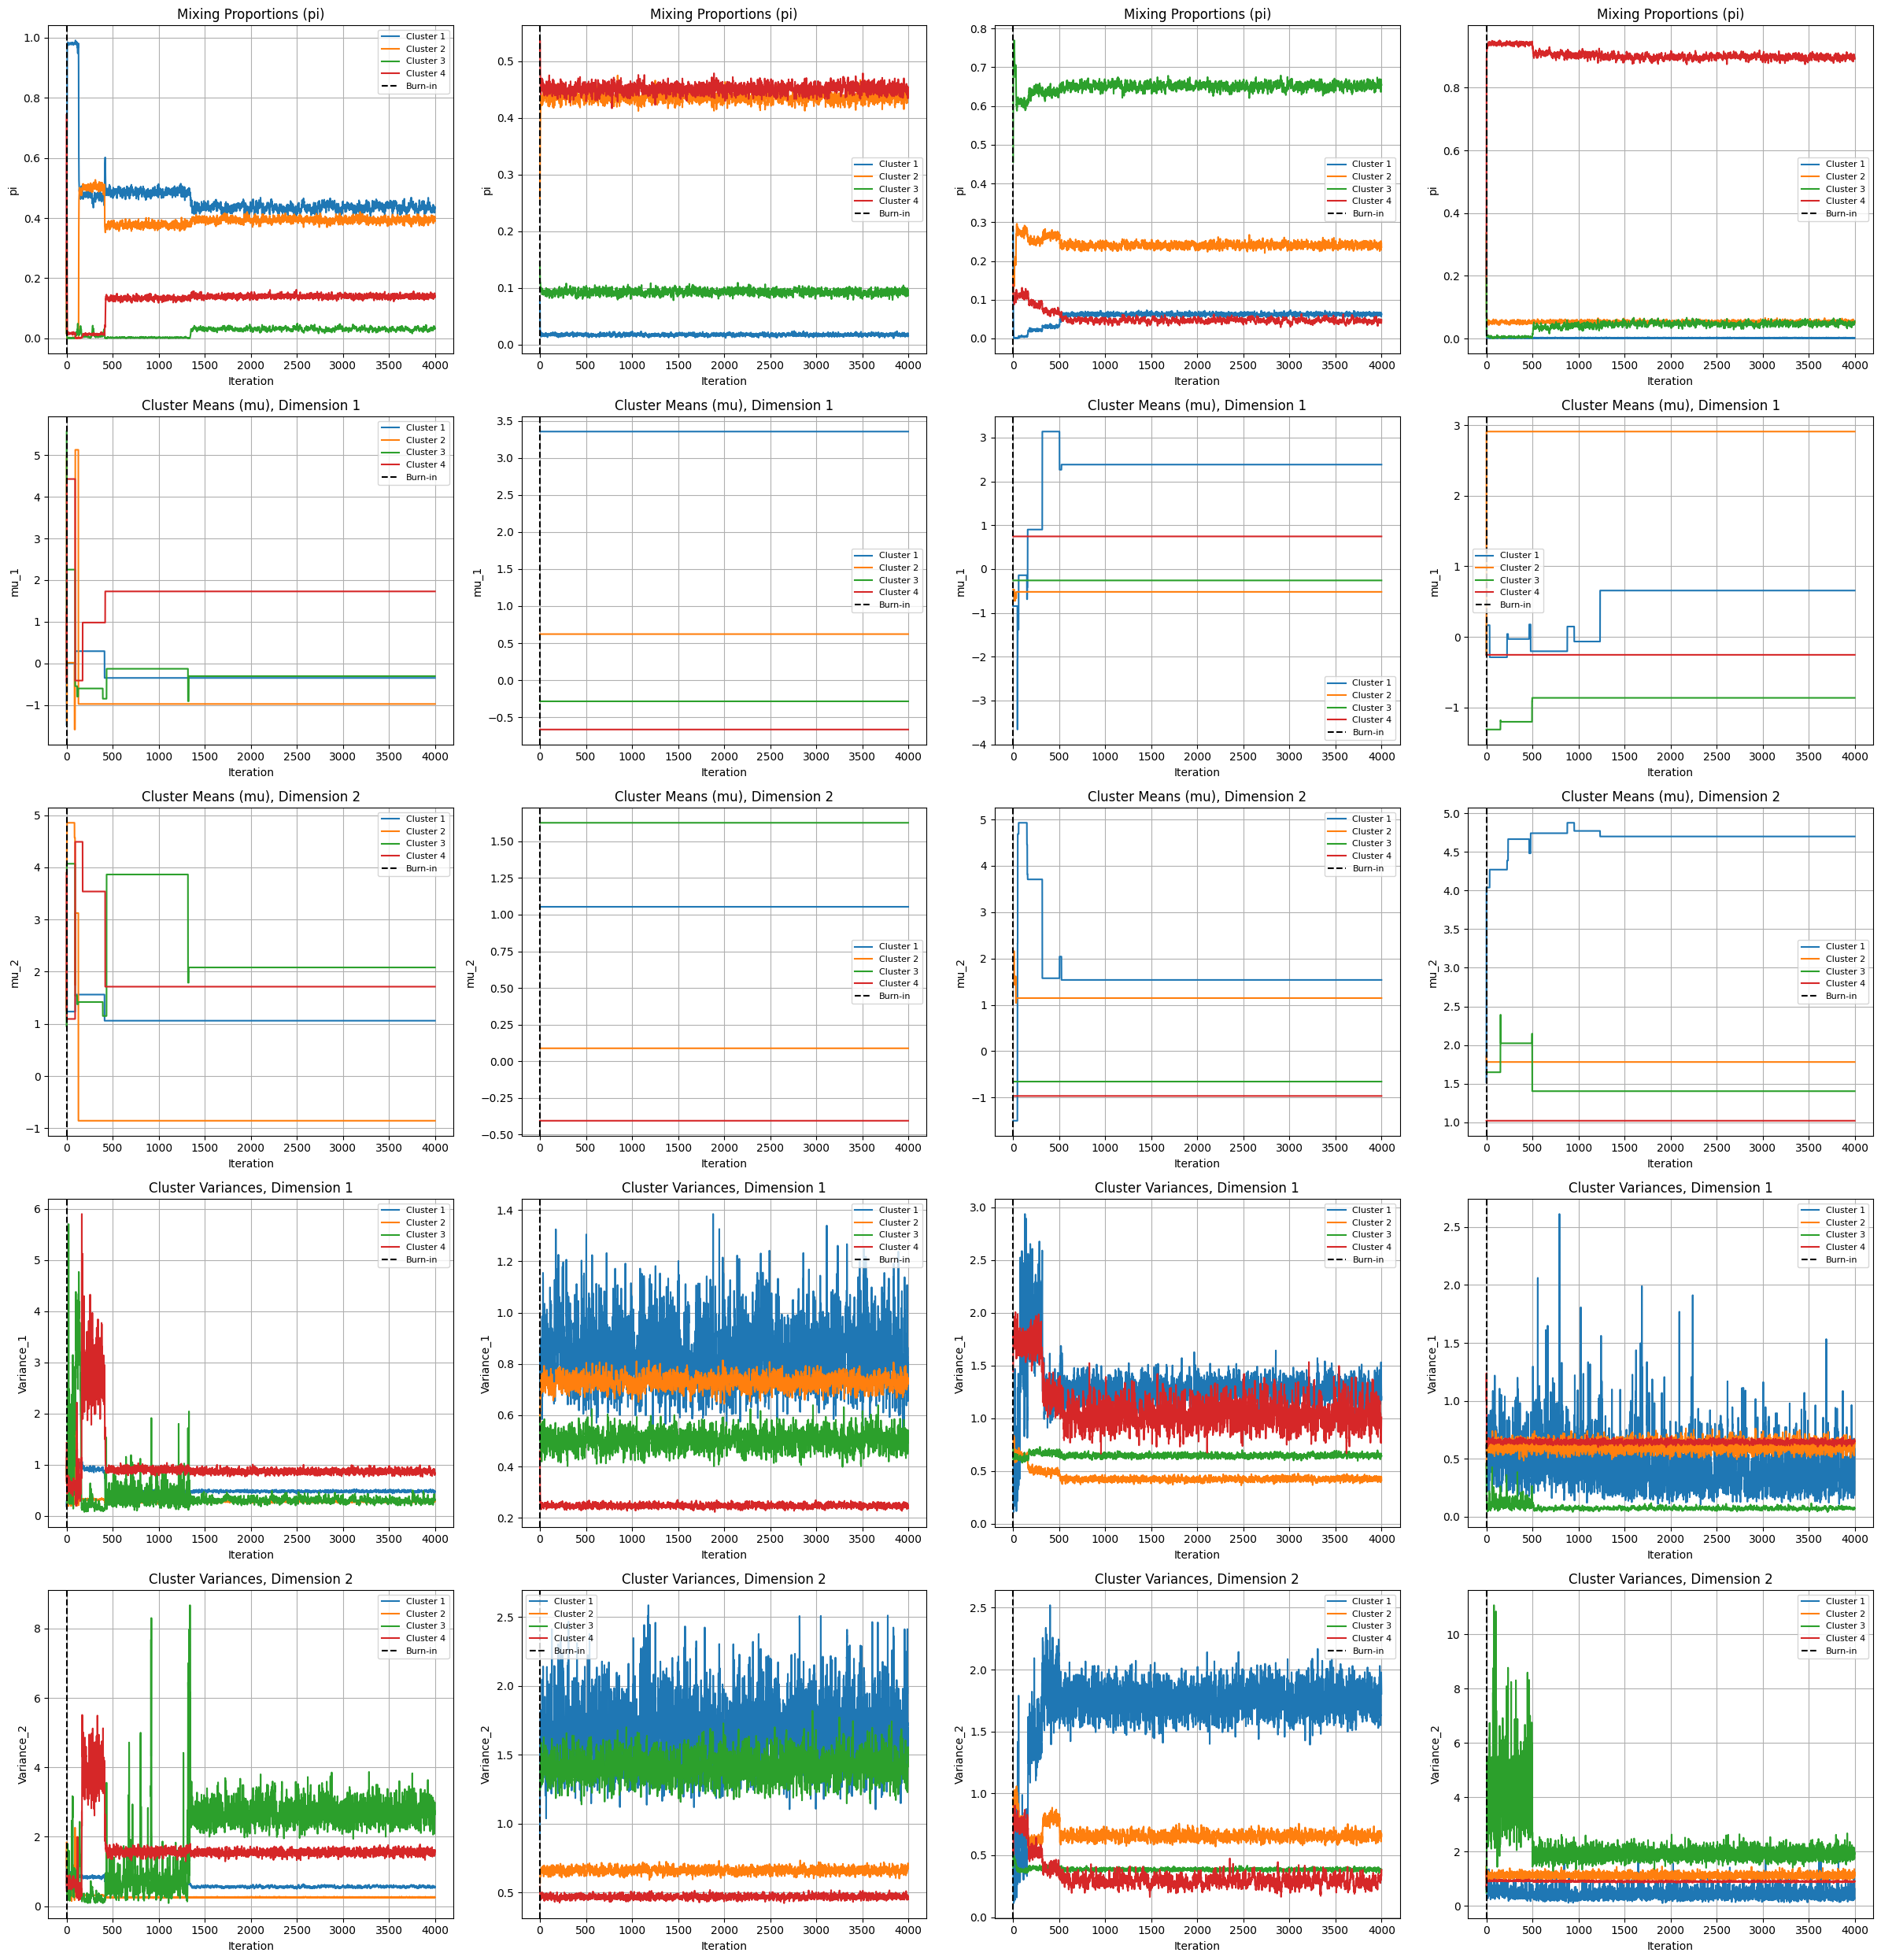

In [4]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h2, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




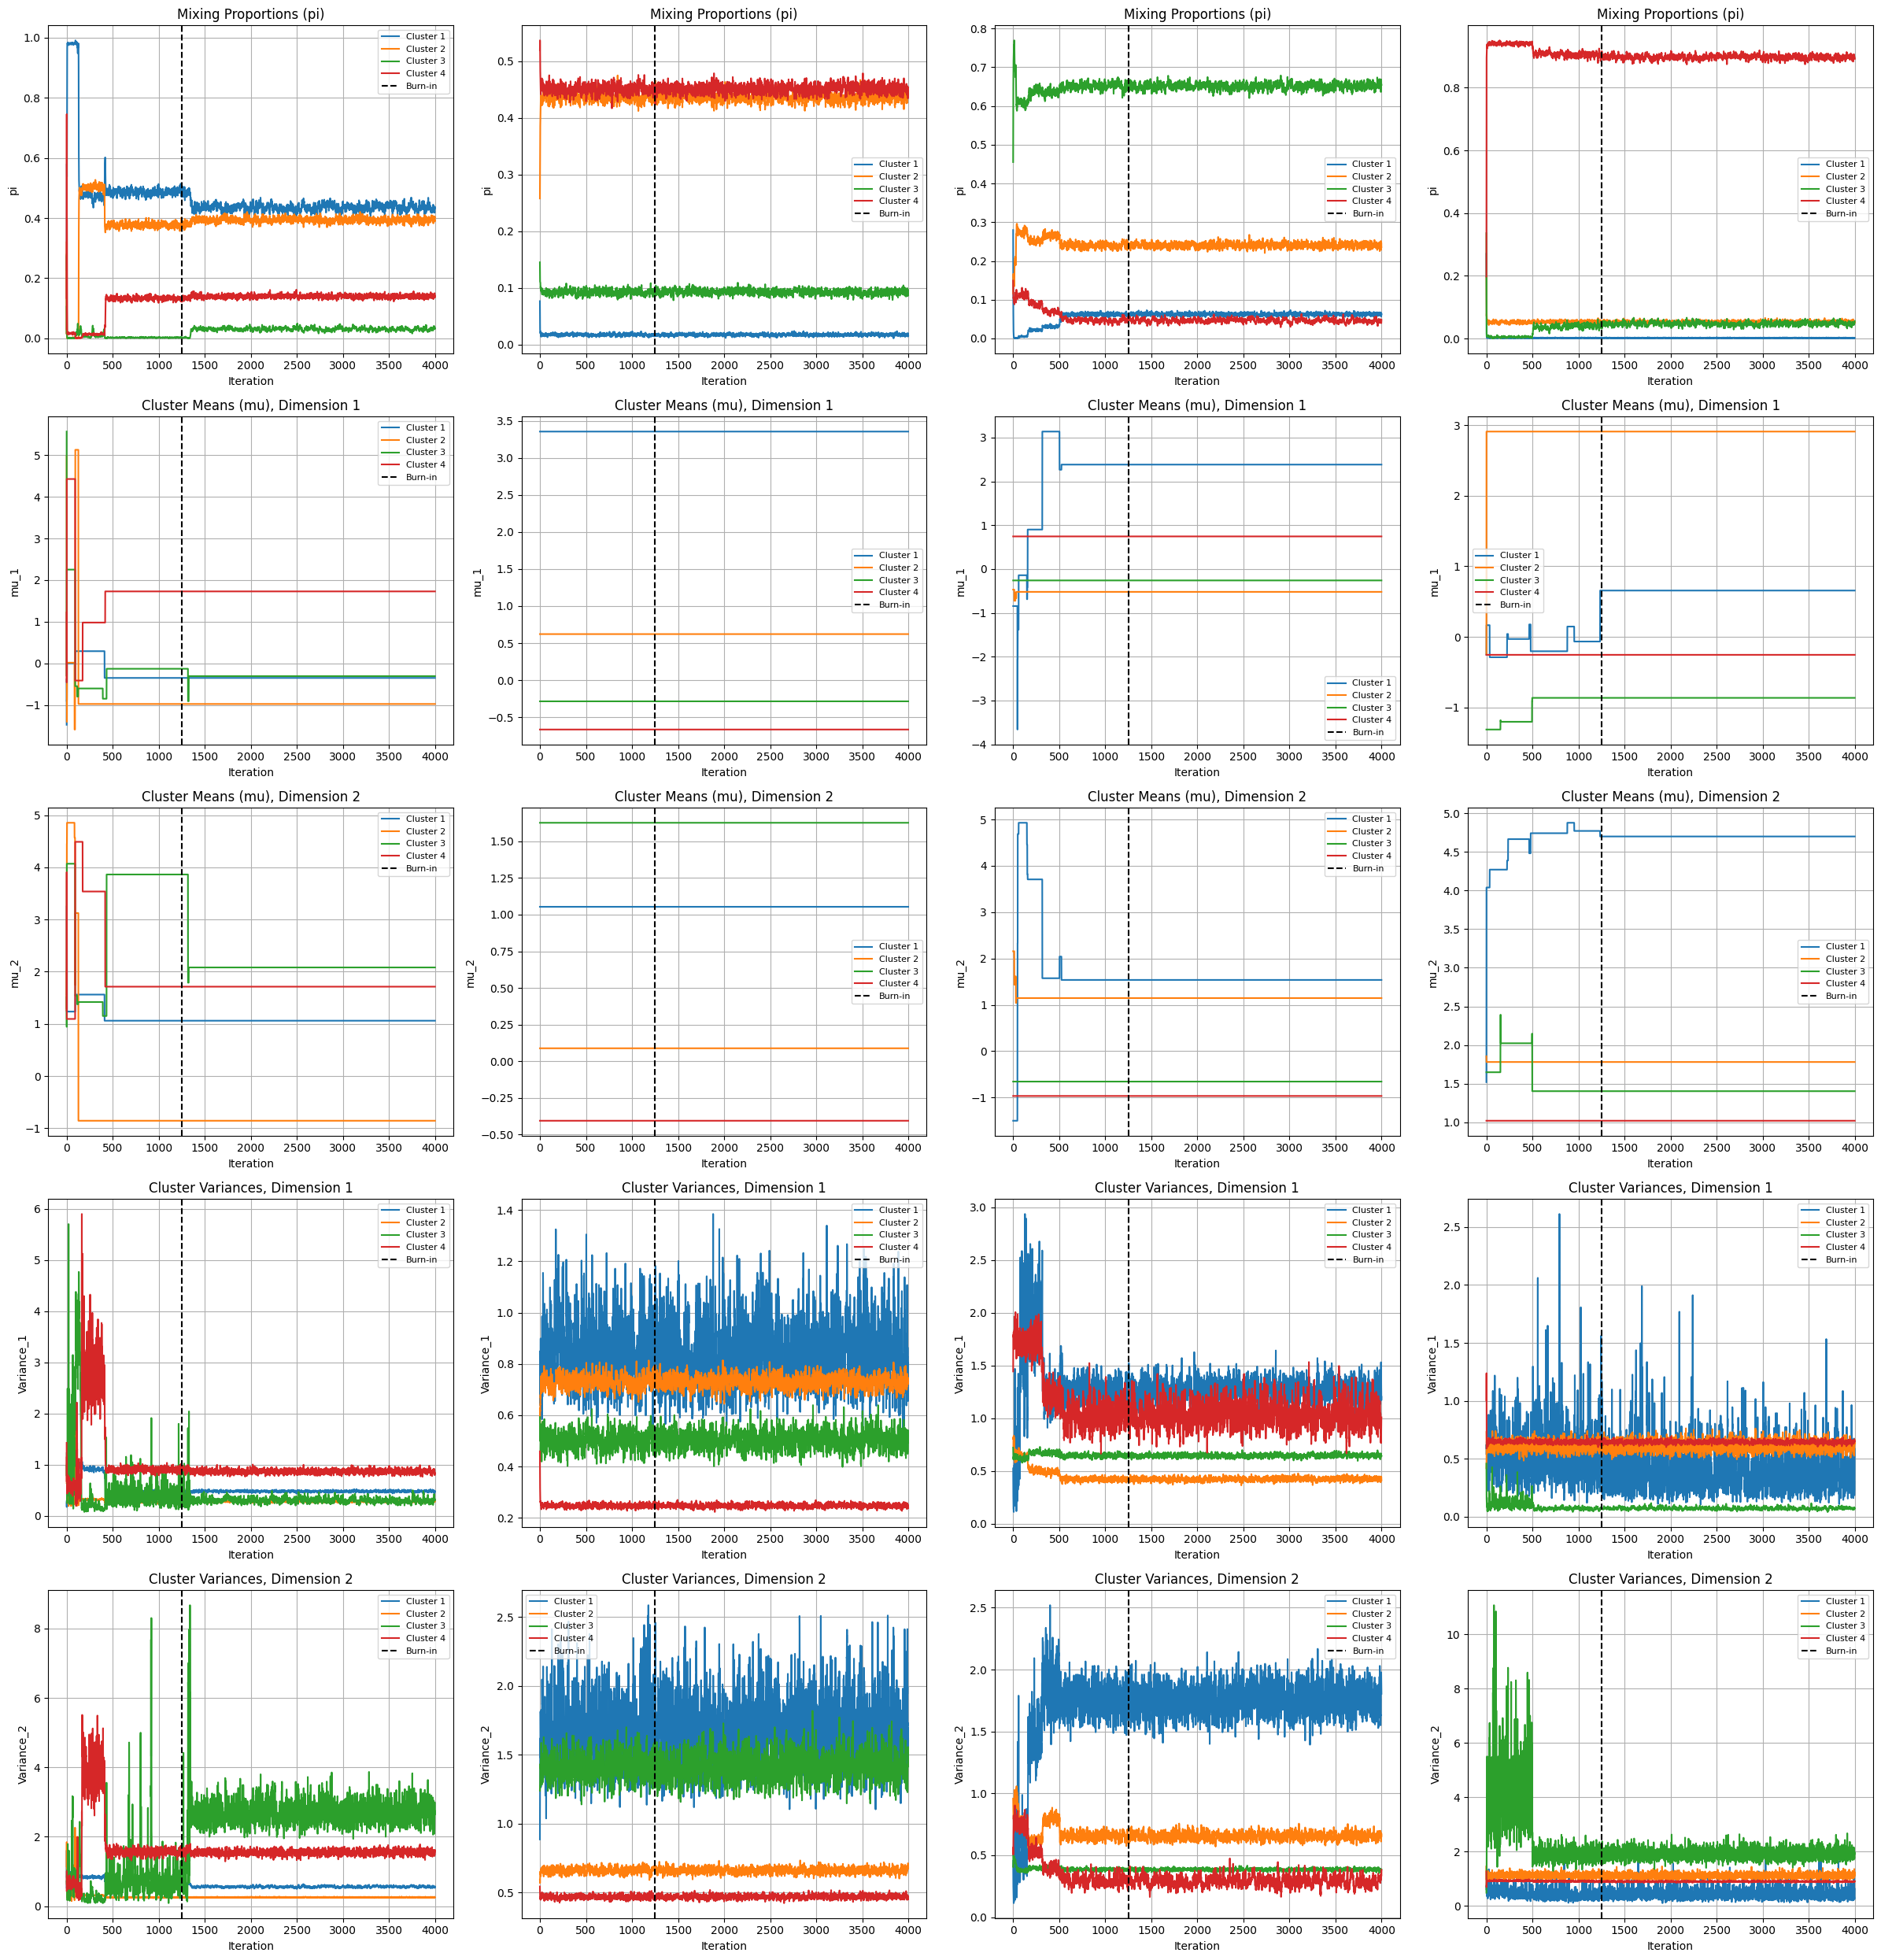

In [5]:
burn_in = 1250
# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in)
plt.tight_layout()
plt.show()


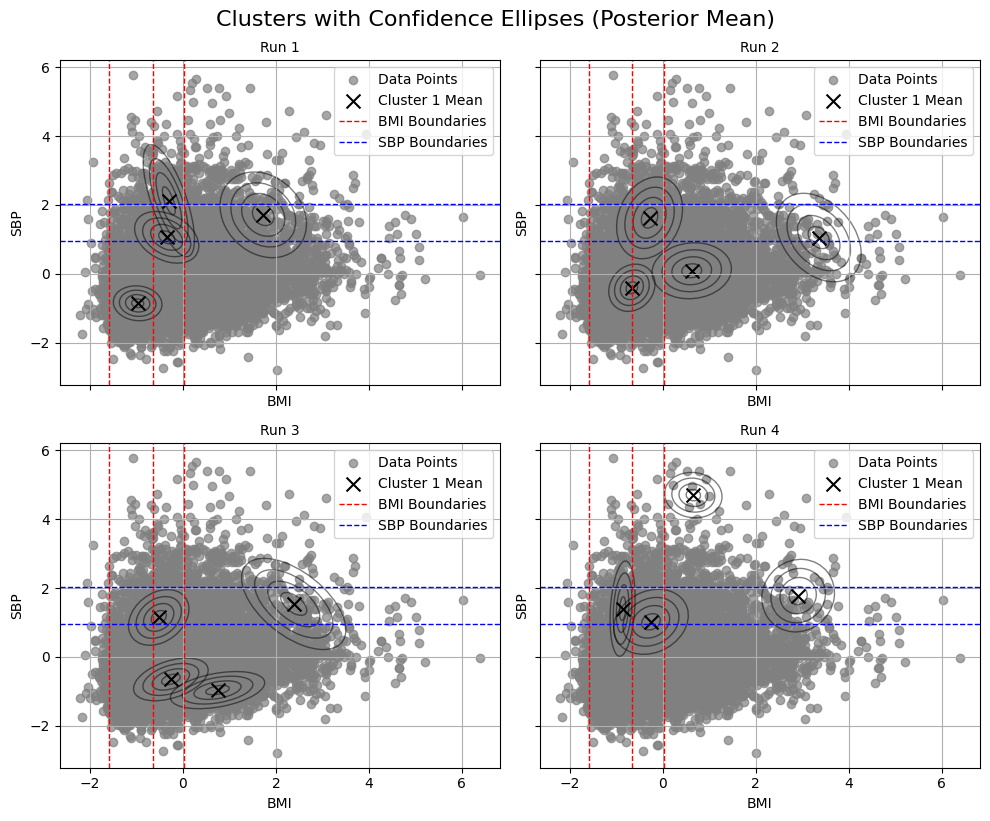

In [6]:
# Compute posterior estimates for each run using samples after burn-in
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    # Use samples after burn-in for this run:
    run_samples_burned = run_samples[burn_in:]
    # Extract cluster means and covariances from the post-burn-in samples:
    mu_samples = np.array([s[1] for s in run_samples_burned])       # shape: (T, K, p)
    sigma_samples = np.array([s[2] for s in run_samples_burned])    # shape: (T, K, p, p)
    
    # Compute the posterior (averaged) estimates:
    posterior_mu = np.mean(mu_samples, axis=0)       # shape: (K, p)
    posterior_sigma = np.mean(sigma_samples, axis=0) # shape: (K, p, p)
    
    # Our plotting function expects sample arrays; we can wrap these in a singleton dimension.
    plot_with_reference_lines(np.expand_dims(posterior_mu, axis=0),
                              np.expand_dims(posterior_sigma, axis=0),
                              X, bmi_bounds, sbp_bounds, ax=ax) 
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Clusters with Confidence Ellipses (Posterior Mean)", fontsize=16, y=1.02)
plt.show()

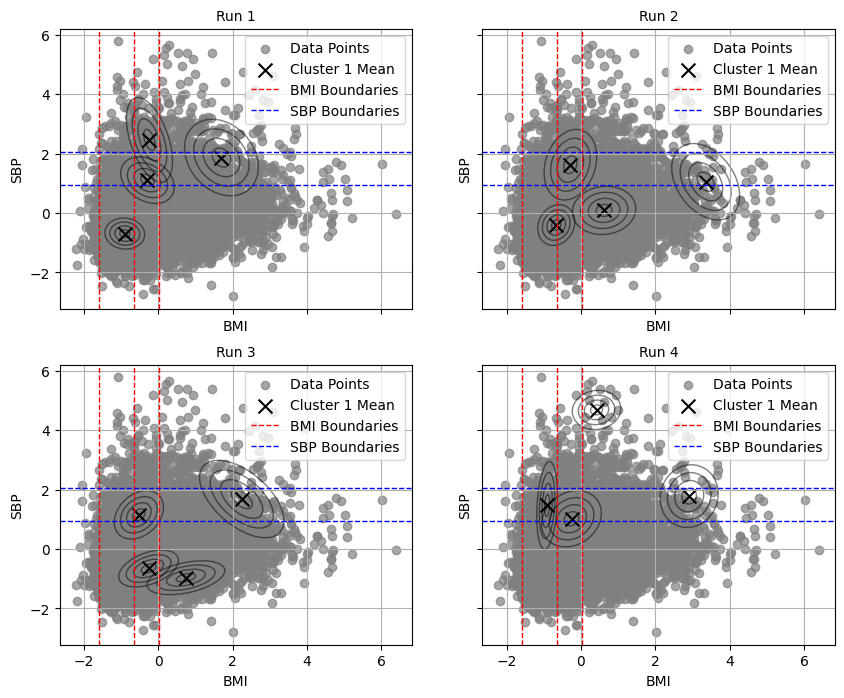

In [7]:
# Compute posterior estimates using only samples after burn-in for one run
run_samples_burned = all_run_samples[0][burn_in:]
pi_samples = np.array([s[0] for s in run_samples_burned])
mu_samples = np.array([s[1] for s in run_samples_burned])
sigma_samples = np.array([s[2] for s in run_samples_burned])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 4000/4000 [04:41<00:00, 14.20it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 4000/4000 [04:41<00:00, 14.19it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 4000/4000 [04:46<00:00, 13.97it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 4000/4000 [04:41<00:00, 14.21it/s]


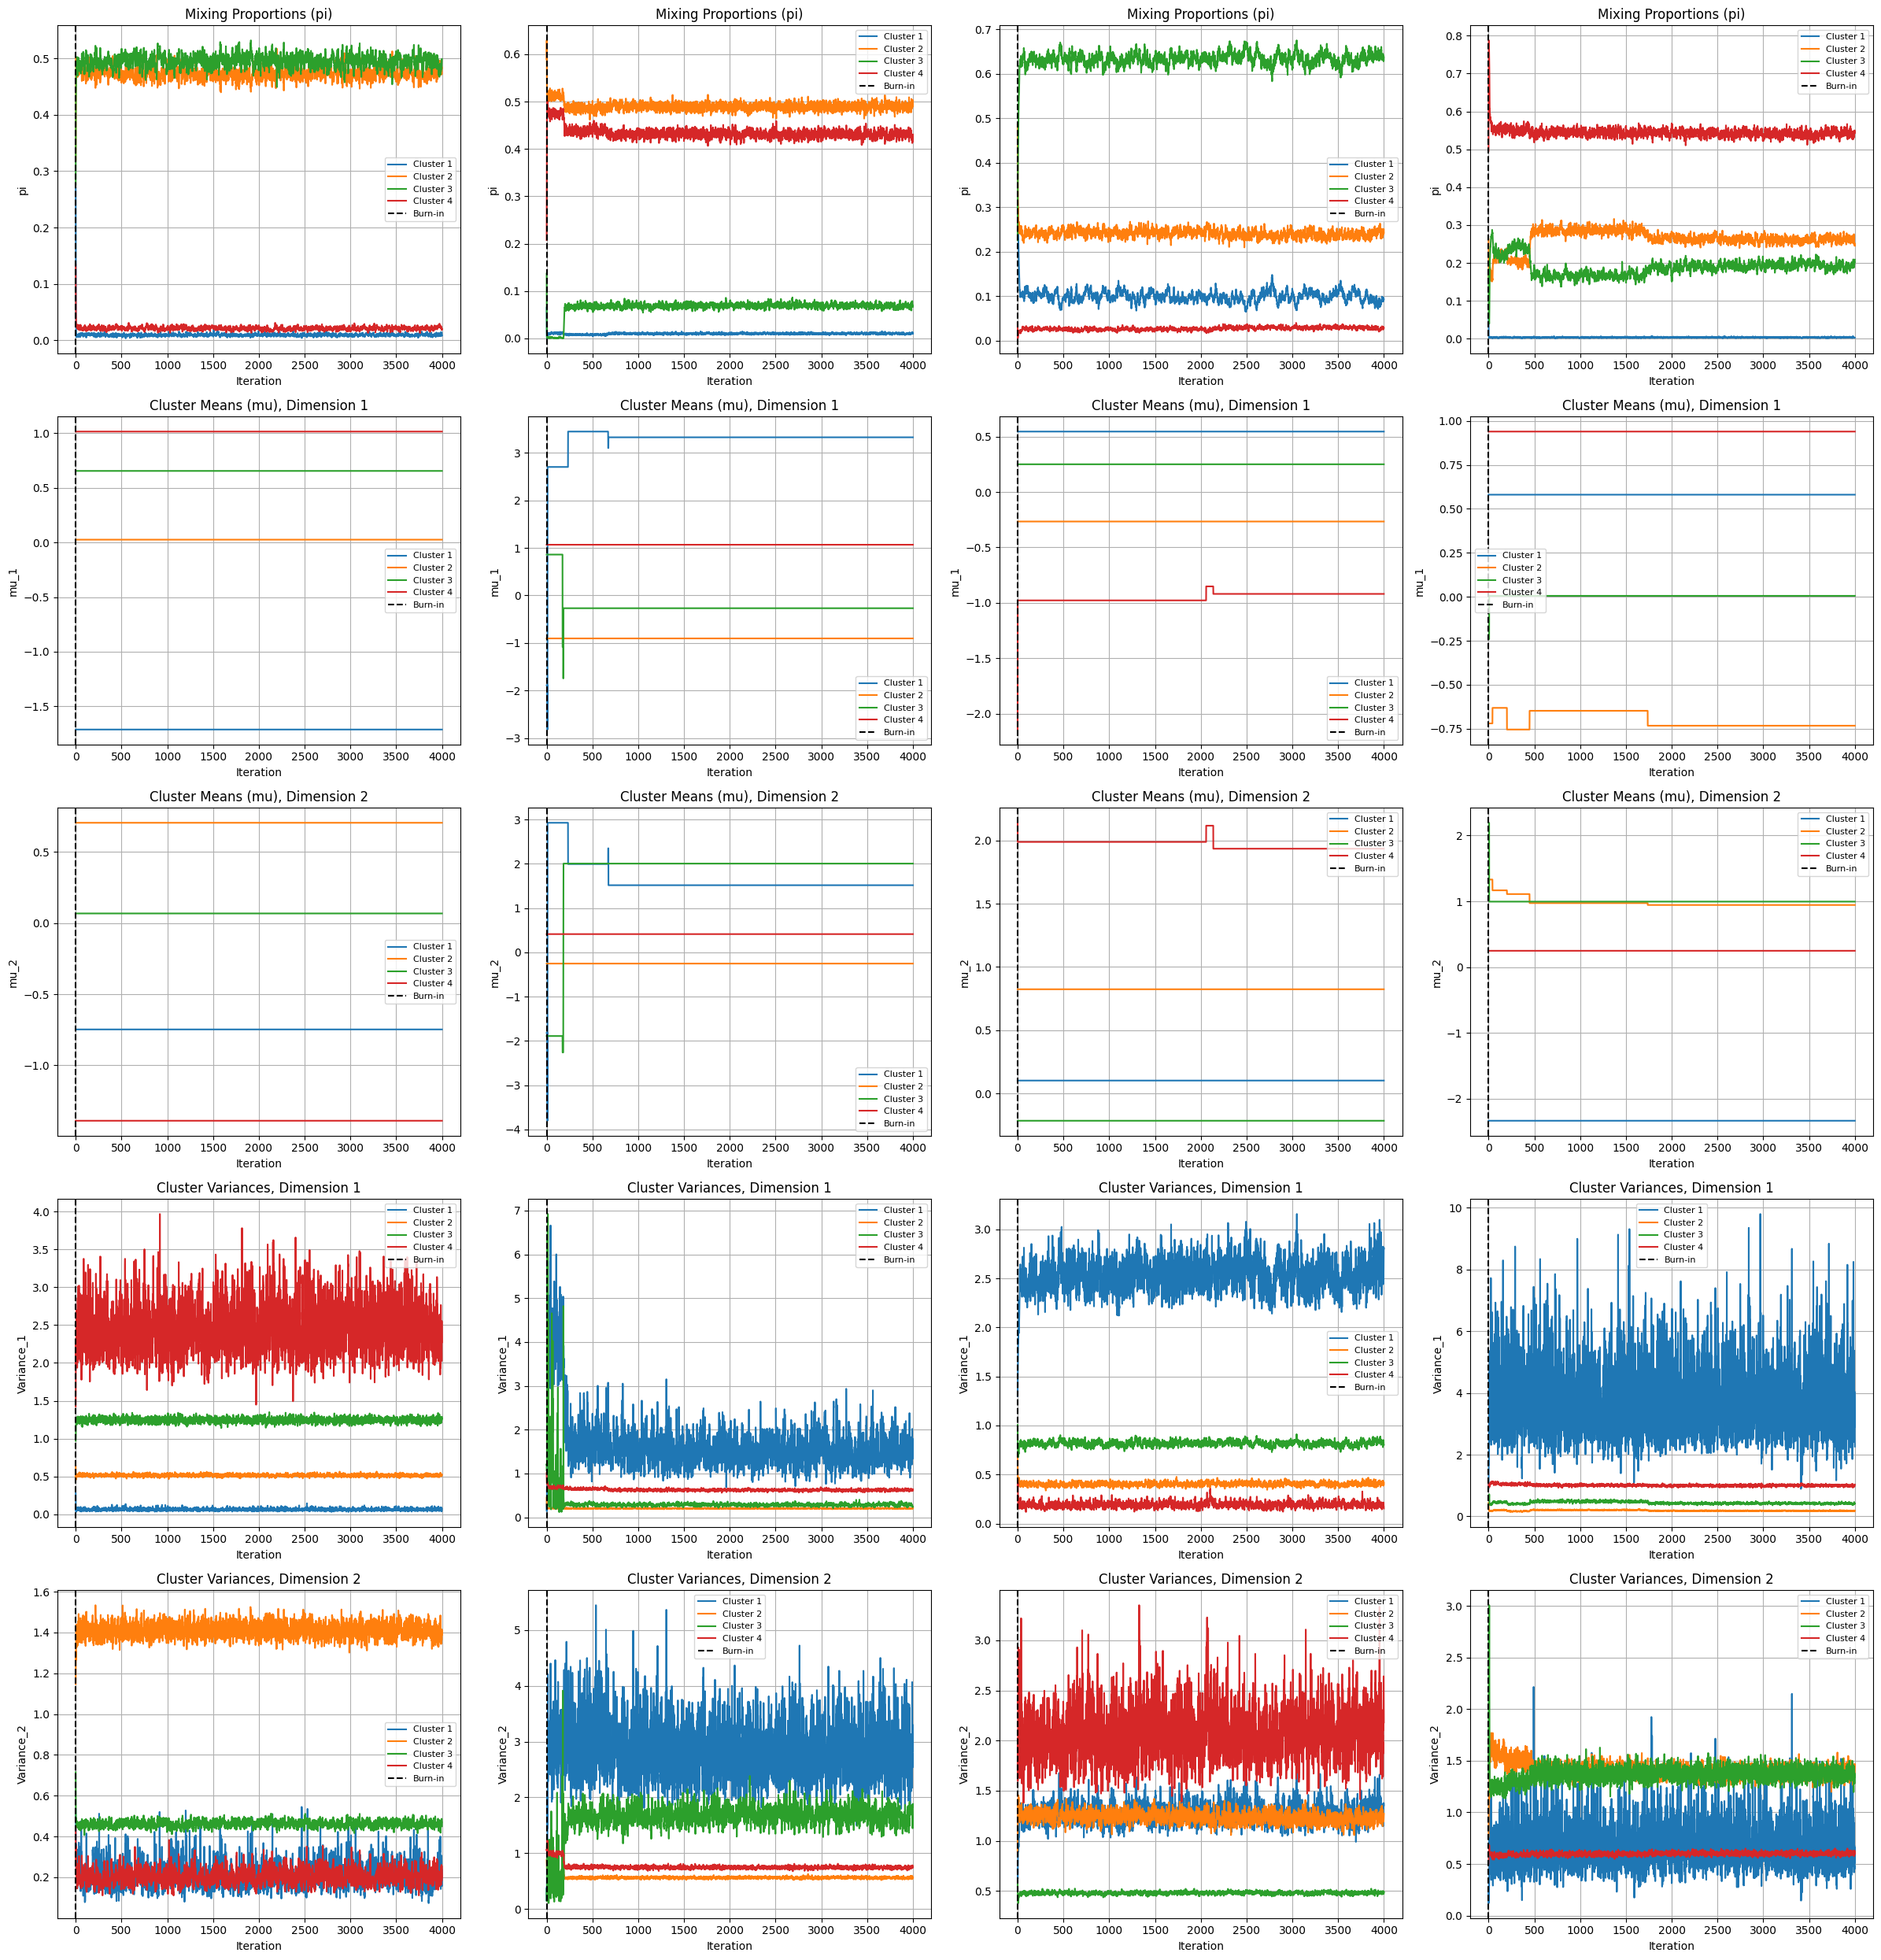

In [9]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




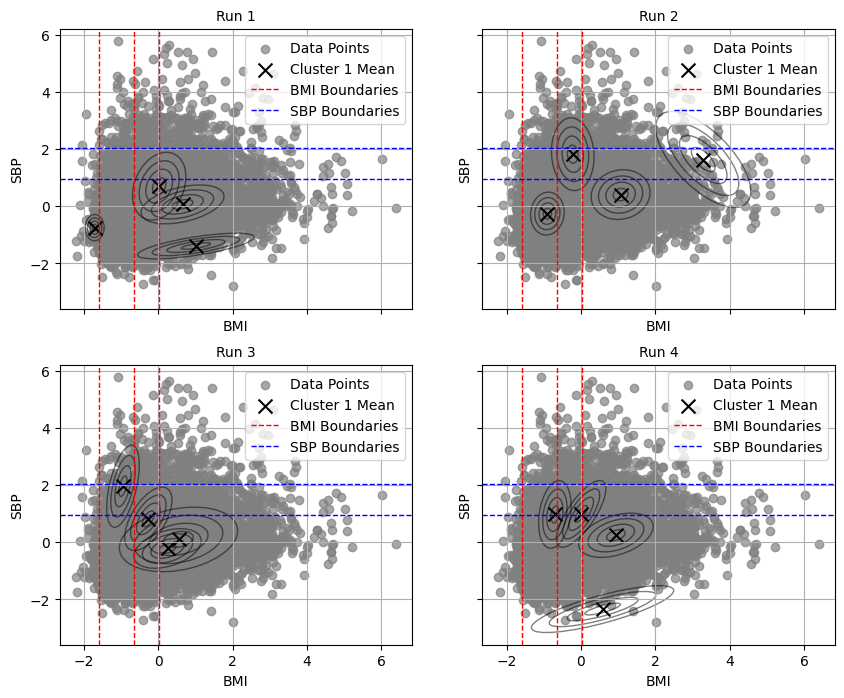

In [10]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


In [ ]:
def h1(mu):
    return np.min(pdist(mu))*2

Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 4000/4000 [04:37<00:00, 14.42it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 4000/4000 [04:39<00:00, 14.32it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 4000/4000 [04:39<00:00, 14.31it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 4000/4000 [04:45<00:00, 13.99it/s]


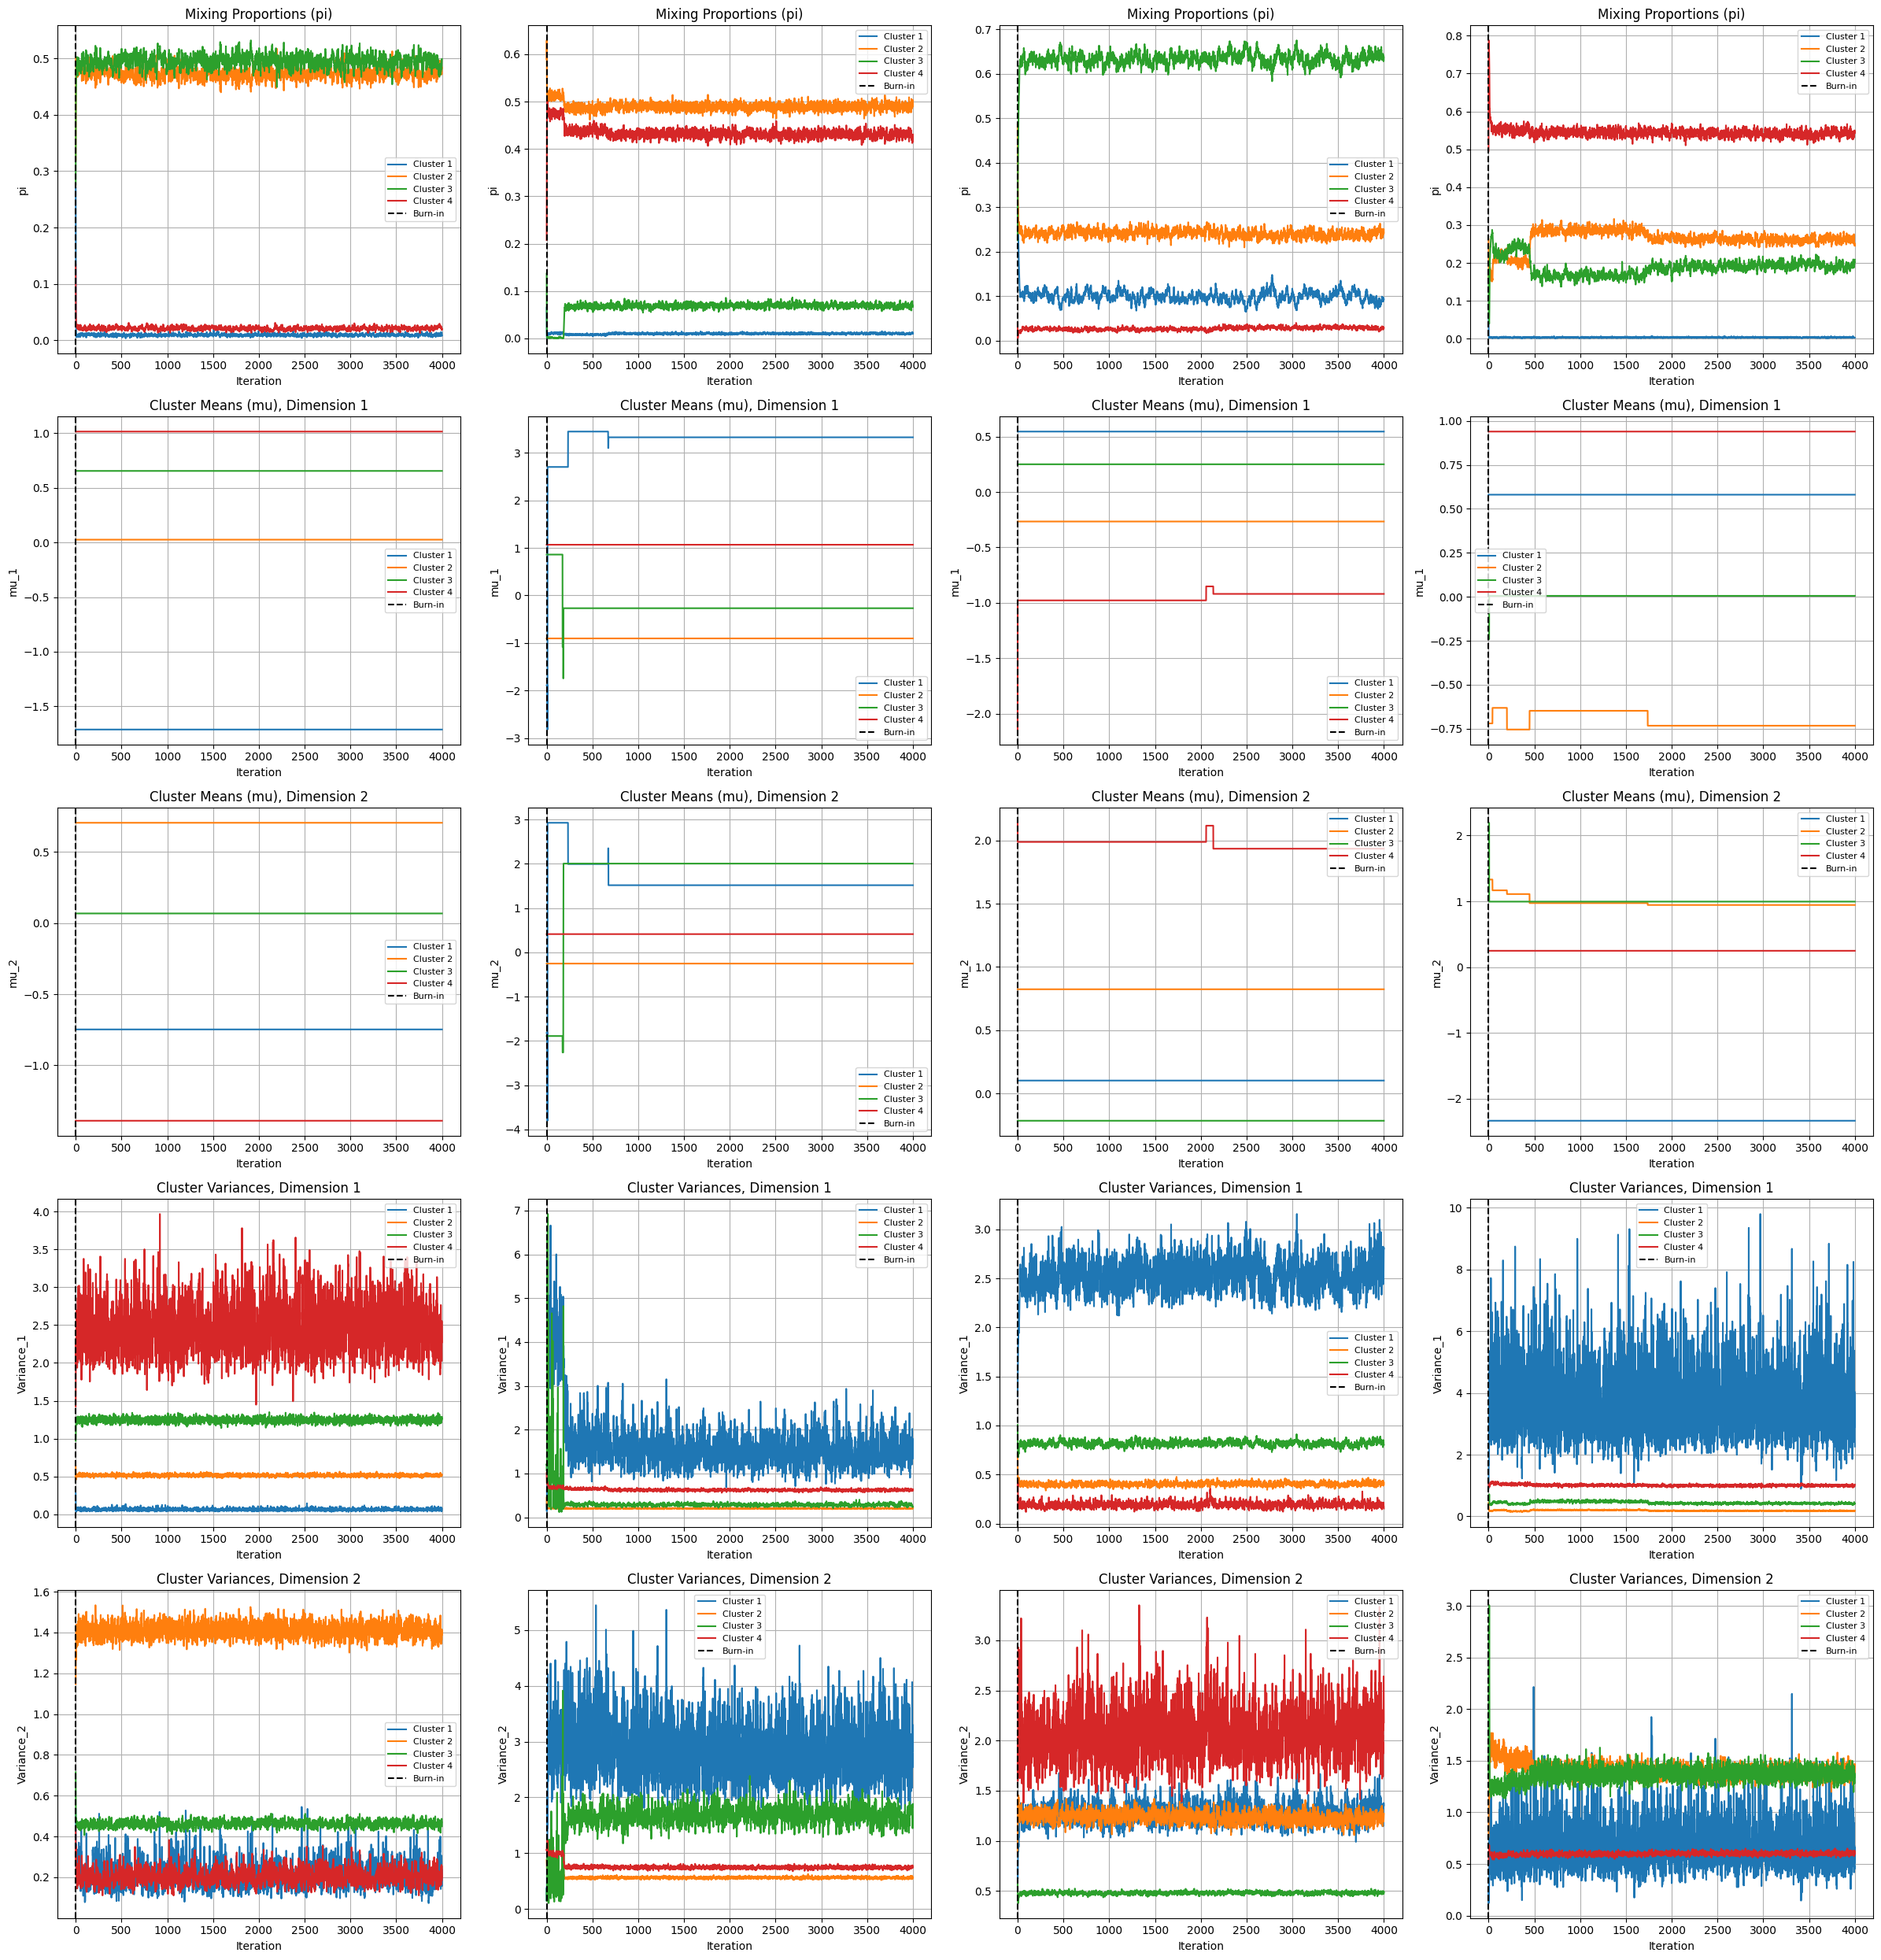

In [16]:
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 4000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




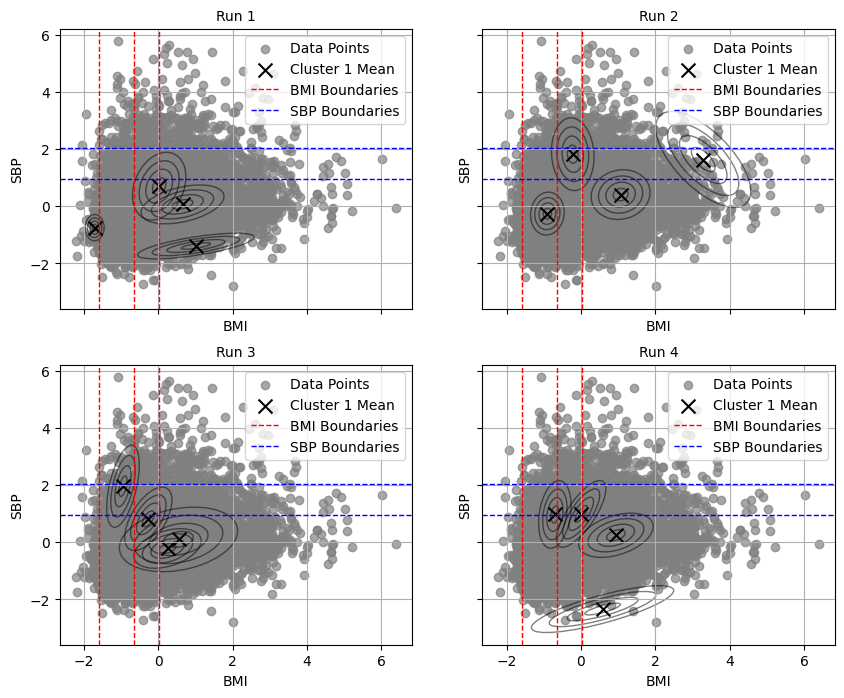

In [17]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)


Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 3000/3000 [03:31<00:00, 14.18it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 3000/3000 [03:32<00:00, 14.13it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 3000/3000 [03:31<00:00, 14.18it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 3000/3000 [03:30<00:00, 14.26it/s]


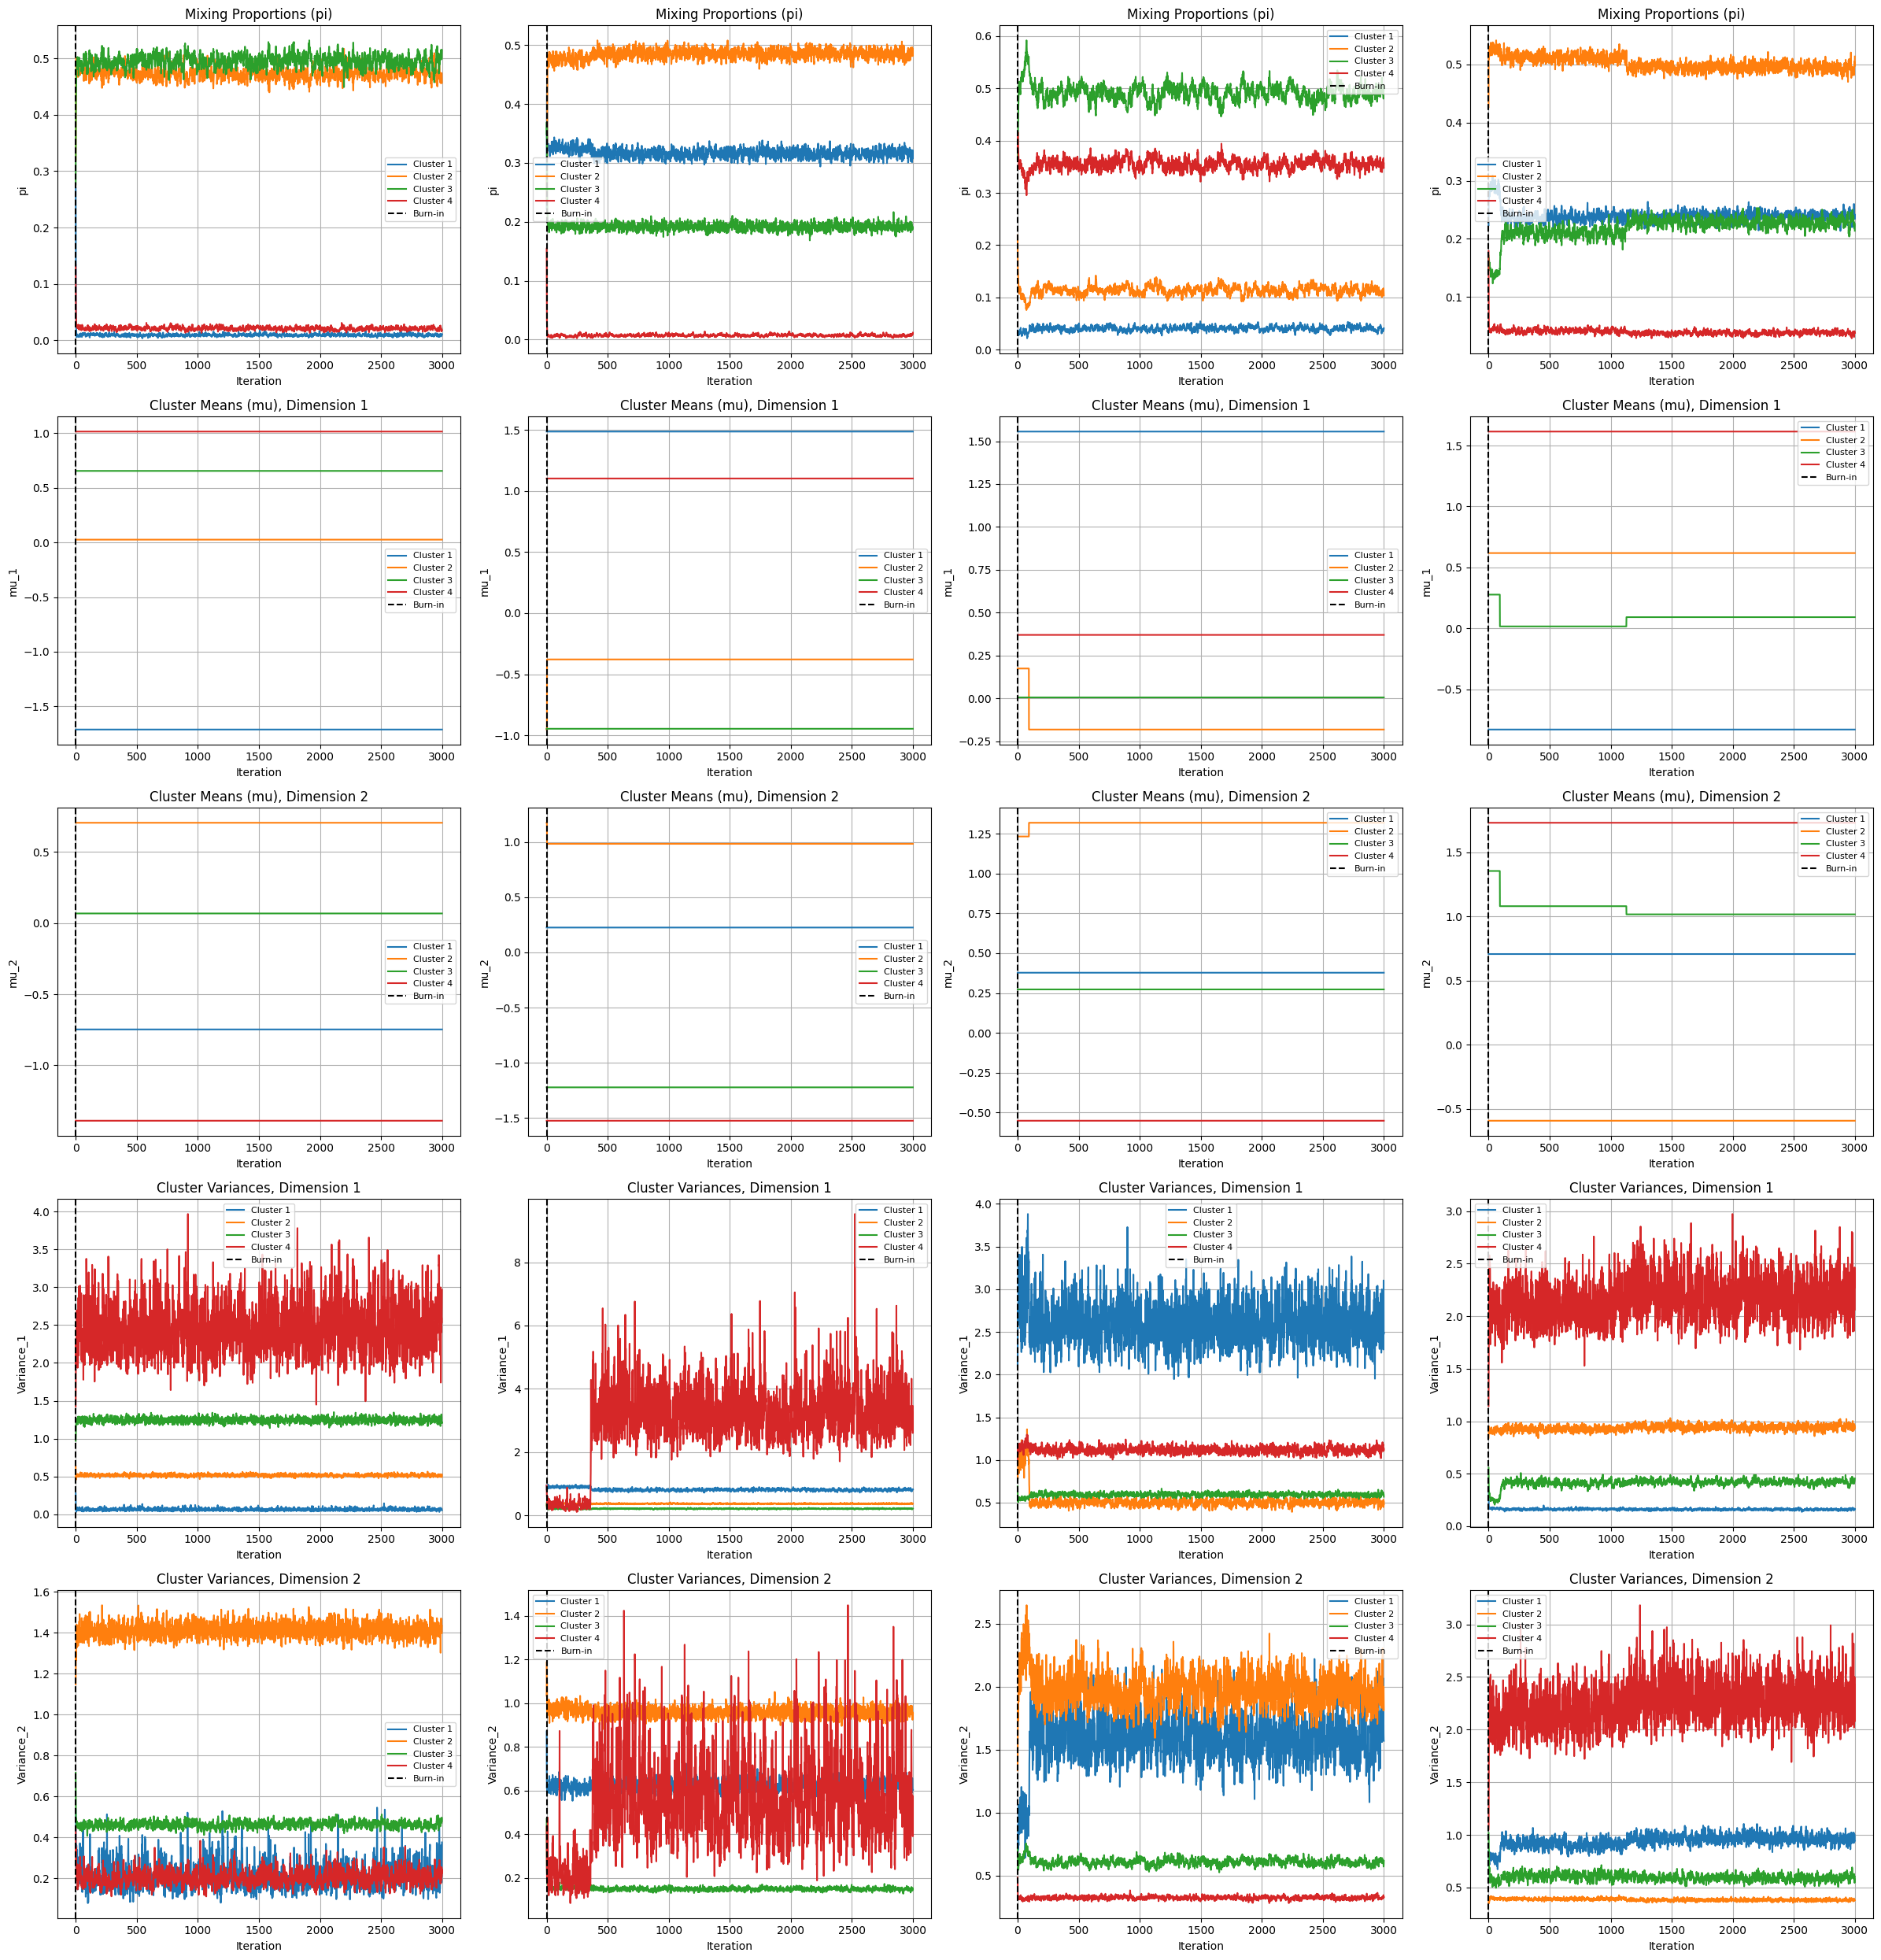

In [22]:
def h1(mu):
    return np.min(pdist(mu))*3
np.random.seed(42)
# Parameters
num_runs = 4
num_iterations = 3000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 

all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = bayesian_repulsive(X, K, num_iterations, h1, 0, bmi_bounds, sbp_bounds)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=0)
plt.tight_layout()
plt.show()




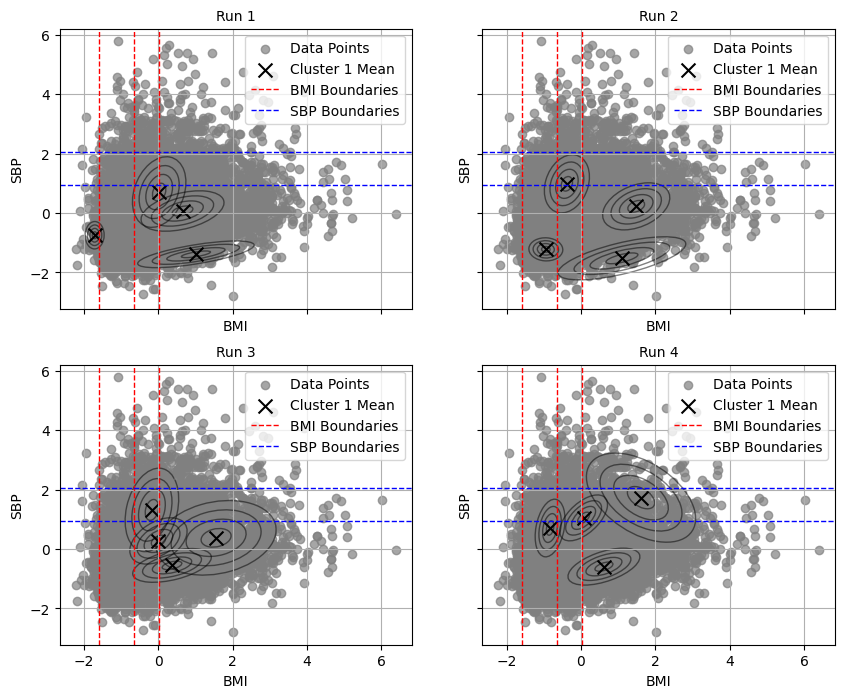

In [24]:

pi_samples = np.array([s[0] for s in all_run_samples[0]])
mu_samples = np.array([s[1] for s in all_run_samples[0]])
sigma_samples = np.array([s[2] for s in all_run_samples[0]])

posterior_pi = pi_samples[-1]
posterior_mu = mu_samples[-1]
posterior_sigma = sigma_samples[-1]


# Plot final clustering with ellipses using the computed posterior estimates
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharex=True, sharey=True)
axes = np.array(axes).flatten()  # Flatten to 1D array for easy iteration

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Extract cluster means
    sigma_samples = np.array([s[2] for s in run_samples])  # Extract cluster covariances
    # Plot the clustering with confidence ellipses on the given axis.
    plot_with_reference_lines(mu_samples, sigma_samples, X, bmi_bounds, sbp_bounds, ax=ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)
